In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [104]:
data_raw = pd.read_csv('data/cleaned_data.csv', parse_dates=['author_date_of_birth', 'publication_date'])

# Feature engineering

In [105]:
data_raw['description_length'] = data_raw['description'].str.len()

In [106]:
data_raw['number_of_pages'] = data_raw['number_of_pages'].astype(int)

In [107]:
categorical_features = ['language', 'category', 'format']

In [108]:
data_raw['language'].unique()

array(['polski', 'angielski', 'niemiecki'], dtype=object)

In [109]:
le = LabelEncoder()
for cat in categorical_features:
    data_raw[cat] = le.fit_transform(data_raw[cat])

In [110]:
rating_features = [f'rating_{i}' for i in range(1, 11)]
scaled_features = [f'scaled_{element}' for element in rating_features]

In [111]:
# to be predicted
threshold = 2000
data_raw['bestseller'] = (data_raw['number_of_people_has'] >= threshold).astype(int)
# data.loc[should_be_bestseller.index, 'possible_bestseller'] = 1
# data['possible_bestseller'] = data['possible_bestseller'].fillna(0).astype(int)


In [112]:
scaler = StandardScaler()

In [113]:
data_raw[scaled_features] = scaler.fit_transform(data_raw[rating_features])

In [114]:
data_raw.columns

Index(['author_average_rating', 'author_number_of_people_read',
       'author_number_of_people_wants_to_read', 'author_date_of_birth',
       'author_number_of_fans', 'author_number_of_books_written',
       'author_number_of_awards', 'number_of_user_opinions',
       'number_of_user_ratings', 'number_of_discussions',
       'number_of_people_read', 'publication_date', 'number_of_pages',
       'series', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5',
       'rating_6', 'rating_7', 'rating_8', 'rating_9', 'rating_10', 'category',
       'part_of_cycle', 'language', 'number_of_people_has',
       'number_of_people_favorite', 'number_of_people_wants_to_read',
       'number_of_people_wants_as_gift', 'number_of_people_currently_read',
       'description', 'format', 'description_length', 'bestseller',
       'scaled_rating_1', 'scaled_rating_2', 'scaled_rating_3',
       'scaled_rating_4', 'scaled_rating_5', 'scaled_rating_6',
       'scaled_rating_7', 'scaled_rating_8', 'sca

In [115]:
data = data_raw.drop(['number_of_user_opinions', 'number_of_user_opinions', 'number_of_user_ratings', 'number_of_discussions', 'number_of_people_read', 'number_of_people_has', 'number_of_people_favorite', 'number_of_people_currently_read', 'number_of_people_wants_to_read', 'number_of_people_wants_as_gift', 'number_of_people_currently_read', 'description', 'series', 'publication_date', 'author_date_of_birth'], axis=1)

In [54]:
data.columns

Index(['author_average_rating', 'author_number_of_people_read',
       'author_number_of_people_wants_to_read', 'author_number_of_fans',
       'author_number_of_books_written', 'author_number_of_awards',
       'number_of_pages', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6', 'rating_7', 'rating_8', 'rating_9', 'rating_10',
       'category', 'part_of_cycle', 'language', 'format', 'description_length',
       'bestseller', 'scaled_rating_1', 'scaled_rating_2', 'scaled_rating_3',
       'scaled_rating_4', 'scaled_rating_5', 'scaled_rating_6',
       'scaled_rating_7', 'scaled_rating_8', 'scaled_rating_9',
       'scaled_rating_10'],
      dtype='object')

In [55]:
correlation_matrix = data.corr()

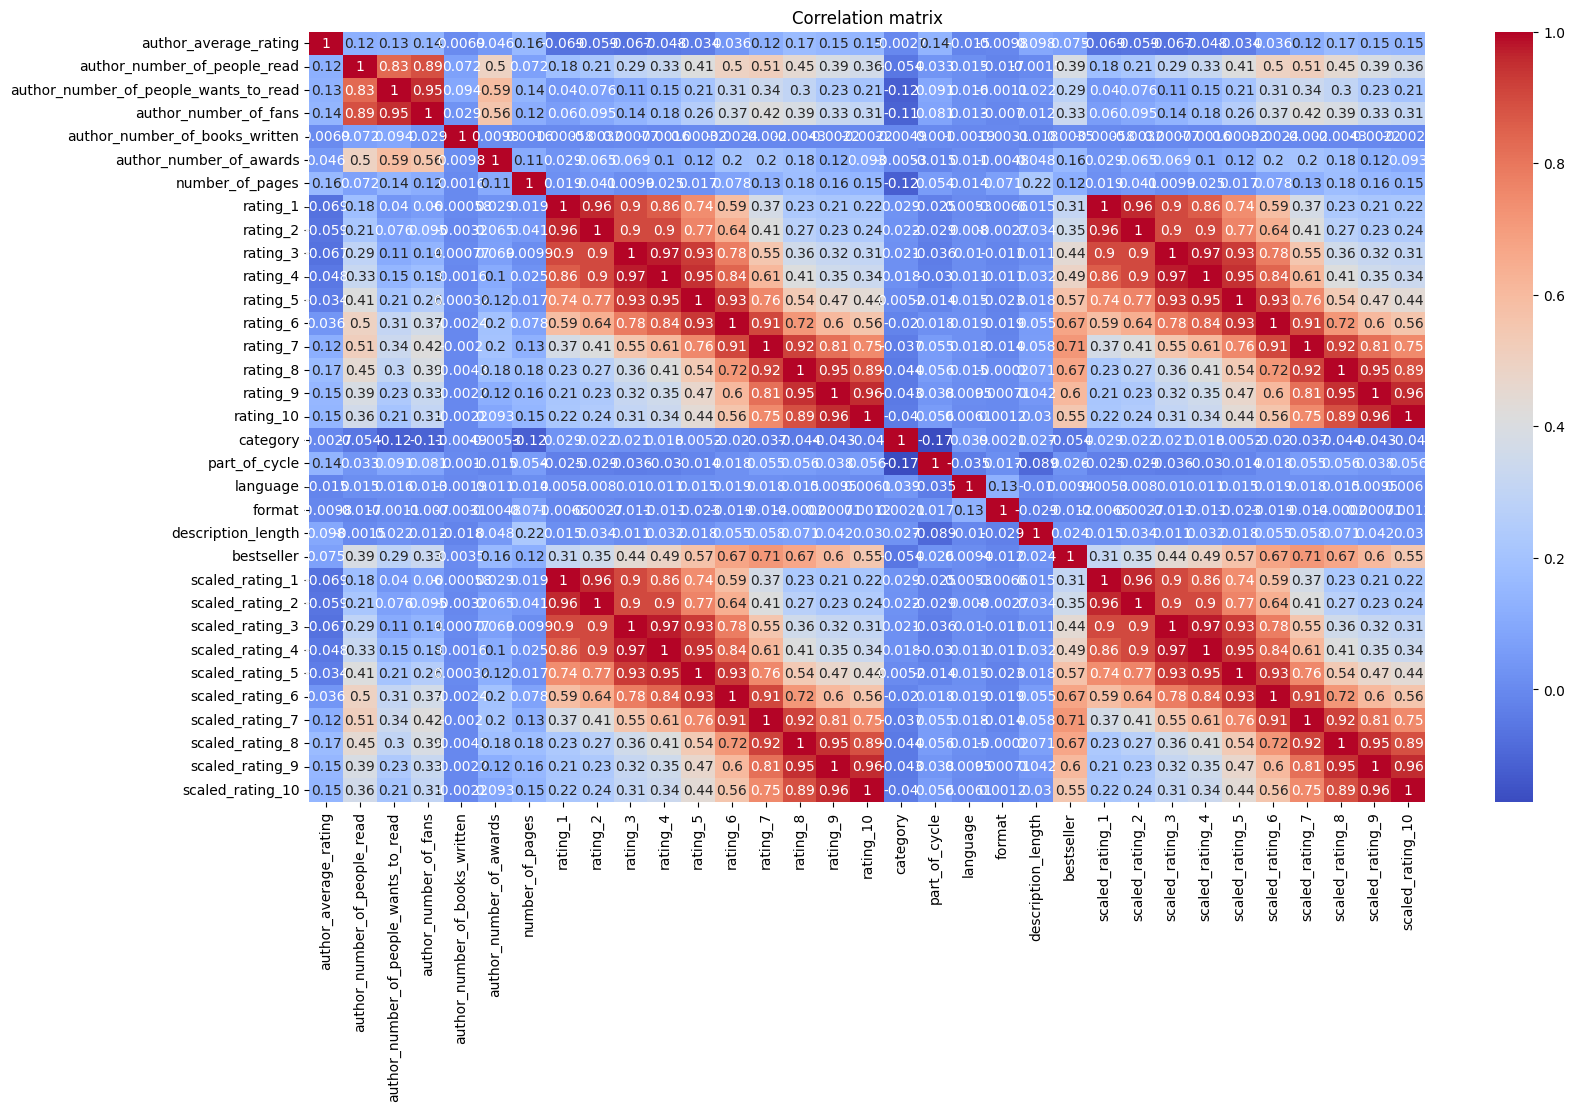

In [56]:
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [57]:
X = data.drop(['bestseller'] + rating_features, axis=1)
y = data['bestseller']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=80085)
print('Train size:', X_train.shape)
print('Test size:', X_test.shape)

Train size: (7593, 22)
Test size: (7593, 22)


In [84]:
from sklearn.feature_selection import f_classif, RFE

# Models

In [85]:
random_forrest_classifier_hyper_parameters = {
    'max_depth': 20,
    'max_features': None,
    'min_samples_leaf': 3,
    'min_samples_split': 10,
    'n_estimators': 150
    }

In [86]:
forest_classifier = RandomForestClassifier(**random_forrest_classifier_hyper_parameters, random_state=66431)
logistic_regression = LogisticRegression(max_iter=500)

In [87]:
X_train.shape

(7593, 22)

In [88]:
rfe_forrest = RFE(forest_classifier, n_features_to_select=20)
rfe_forrest.fit(X_train, y_train)
rfe_logistic = RFE(logistic_regression, n_features_to_select=20)
rfe_logistic.fit(X_train, y_train)

/home/mateusz/dev/lubimyczytac_project/lubimyczytac/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mateusz/dev/lubimyczytac_project/lubimyczytac/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

RFE(estimator=LogisticRegression(max_iter=500), n_features_to_select=20)

In [89]:
selected_features_forrest = X_train.columns[rfe_forrest.support_]
print('Selected features:', selected_features_forrest)
selected_features_logistic = X_train.columns[rfe_logistic.support_]
print('Selected features:', selected_features_logistic)

Selected features: Index(['author_average_rating', 'author_number_of_people_read',
       'author_number_of_people_wants_to_read', 'author_number_of_fans',
       'author_number_of_books_written', 'author_number_of_awards',
       'number_of_pages', 'category', 'part_of_cycle', 'description_length',
       'scaled_rating_1', 'scaled_rating_2', 'scaled_rating_3',
       'scaled_rating_4', 'scaled_rating_5', 'scaled_rating_6',
       'scaled_rating_7', 'scaled_rating_8', 'scaled_rating_9',
       'scaled_rating_10'],
      dtype='object')
Selected features: Index(['author_average_rating', 'author_number_of_people_read',
       'author_number_of_fans', 'author_number_of_books_written',
       'author_number_of_awards', 'number_of_pages', 'category',
       'part_of_cycle', 'language', 'format', 'scaled_rating_1',
       'scaled_rating_2', 'scaled_rating_3', 'scaled_rating_4',
       'scaled_rating_5', 'scaled_rating_6', 'scaled_rating_7',
       'scaled_rating_8', 'scaled_rating_9', 'scal

In [90]:
# random forrest classifier
forest_classifier.fit(X_train[selected_features_forrest], y_train)
y_forrest_pred = forest_classifier.predict(X_test[selected_features_forrest])

# logistic regression
logistic_regression.fit(X_train[selected_features_logistic], y_train)
y_logistic_pred = logistic_regression.predict(X_test[selected_features_logistic])

/home/mateusz/dev/lubimyczytac_project/lubimyczytac/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
print('forrest', accuracy_score(y_test, y_forrest_pred))
print('logistic', accuracy_score(y_test, y_logistic_pred))

forrest 0.9909706546275395
logistic 0.9915349887133182


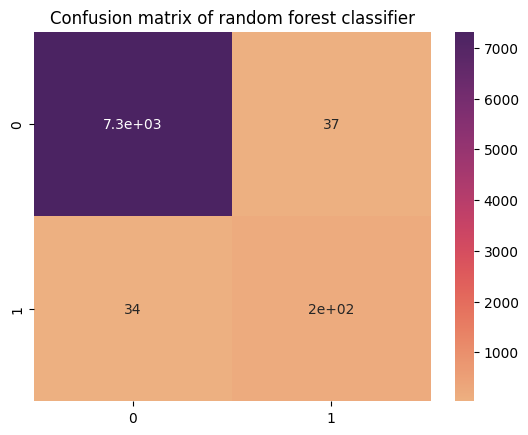

In [91]:
cm = confusion_matrix(y_test, y_forrest_pred)
sns.heatmap(cm, annot=True, cmap='flare')
plt.title('Confusion matrix of random forest classifier')
plt.show()

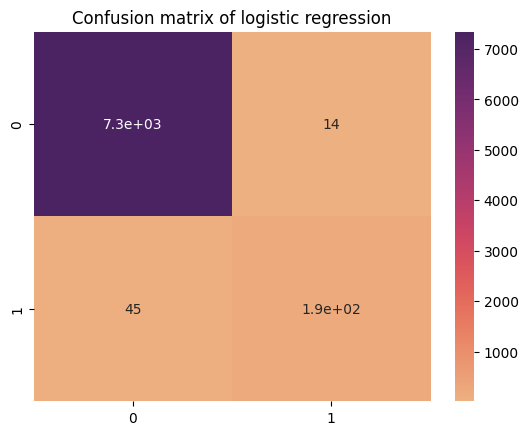

In [92]:
cm = confusion_matrix(y_test, y_logistic_pred)
sns.heatmap(cm, annot=True, cmap='flare')
plt.title('Confusion matrix of logistic regression')
plt.show()

In [93]:
confusion_matrix(y_test, y_forrest_pred)

array([[7319,   37],
       [  34,  203]])

In [120]:
books_df = pd.read_csv('data/books_data.csv')

/tmp/ipykernel_110165/1884596977.py:1: DtypeWarning: Columns (76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv('data/books_data.csv')


In [135]:
predicted_best_sellers_index = y_test.index[(y_forrest_pred == y_test) & (y_forrest_pred == 1)]

In [137]:
bestsellers_predicted = books_df.loc[predicted_best_sellers_index, ['Tytuł oryginału', 'author']]

In [138]:
bestsellers_predicted.to_csv('data/bestsellers_predicted.csv', index=False)

In [36]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV

recall_scorer = make_scorer(recall_score)

# Example: Tune a RandomForestClassifier with GridSearchCV
param_grid = {
    "n_estimators": [100, 150, 300, 500],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ["sqrt", "log2", None]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring=recall_scorer, cv=5)
grid.fit(X_train, y_train)
print("Best Recall:", grid.best_score_)
print("Best Params:", grid.best_params_)

Best Recall: 0.8242559523809524
Best Params: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 150}


In [79]:
optimized_forest = grid.best_estimator_

In [80]:
optimized_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=None, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=150)

In [81]:
y_optimized_forest_pred = optimized_forest.predict(X_test)

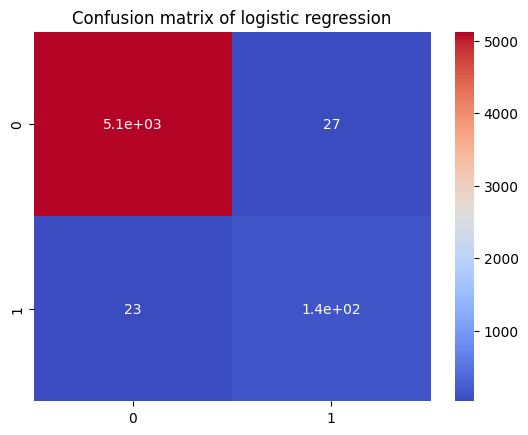

In [82]:
cm = confusion_matrix(y_test, y_optimized_forest_pred)
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.title('Confusion matrix of logistic regression')
plt.show()